## Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

### Exercise 1: Sentiment Analysis (warm up)

In this first exercise we will start from a pre-trained BERT transformer and build up a model able to perform text sentiment analysis. Transformers are complex beasts, so we will build up our pipeline in several explorative and incremental steps.

#### Exercise 1.1: Dataset Splits and Pre-trained model
There are a many sentiment analysis datasets, but we will use one of the smallest ones available: the [Cornell Rotten Tomatoes movie review dataset](cornell-movie-review-data/rotten_tomatoes), which consists of 5,331 positive and 5,331 negative processed sentences from the Rotten Tomatoes movie reviews.

**Your first task**: Load the dataset and figure out what splits are available and how to get them. Spend some time exploring the dataset to see how it is organized. Note that we will be using the [HuggingFace Datasets](https://huggingface.co/docs/datasets/en/index) library for downloading, accessing, splitting, and batching data for training and evaluation.

In [1]:
import numpy as np
from datasets import load_dataset, get_dataset_split_names
from transformers import AutoTokenizer, AutoModel
from transformers import pipeline
import torch
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoFeatureExtractor
from transformers import DistilBertModel, DistilBertTokenizer, EarlyStoppingCallback
from datasets import load_from_disk

import evaluate
import wandb
import random

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#from tdc.multi_pred.anndata_dataset import DataLoader
#from tdc import tdc_hf_interface
#from tdc.model_server.tokenizers.scgpt import scGPTTokenizer
import torch

In [3]:
dataset_id = "cornell-movie-review-data/rotten_tomatoes"
ds_train = load_dataset(dataset_id, split="train")
ds_test = load_dataset(dataset_id, split="test")
ds_validation = load_dataset(dataset_id, split="validation")

In [4]:
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [6]:
ds_validation

Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})

In [7]:
ds_test

Dataset({
    features: ['text', 'label'],
    num_rows: 1066
})

In [8]:
print(f"Labels: {np.unique(ds_train['label'])}")
print(f"Label 0: negative review")
print(f"Label 1: positive review")

Labels: [0 1]
Label 0: negative review
Label 1: positive review


In [9]:
for i in random.sample(range(0, 8000), 3):
    print(f"Index: {i}")
    print(f"Review text example: {ds_train['text'][i]}")
    print(f"Label example: {ds_train['label'][i]}")
    print(" ")

Index: 415
Review text example: the whole cast looks to be having so much fun with the slapstick antics and silly street patois , tossing around obscure expressions like bellini and mullinski , that the compact 86 minutes breezes by .
Label example: 1
 
Index: 4194
Review text example: this is historical filmmaking without the balm of right-thinking ideology , either liberal or conservative . mr . scorsese's bravery and integrity in advancing this vision can hardly be underestimated .
Label example: 1
 
Index: 5842
Review text example: shrewd but pointless .
Label example: 0
 


#### Exercise 1.2: A Pre-trained BERT and Tokenizer

The model we will use is a *very* small BERT transformer called [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased) this model was trained (using self-supervised learning) on the same corpus as BERT but using the full BERT base model as a *teacher*.

**Your next task**: Load the Distilbert model and corresponding tokenizer. Use the tokenizer on a few samples from the dataset and pass the tokens through the model to see what outputs are provided. I suggest you use the [`AutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) class (and the `from_pretrained()` method) to load the model and `AutoTokenizer` to load the tokenizer).

In [10]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

In [11]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [12]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [13]:
encoded_inputs = tokenizer(ds_train[:5]['text'], padding=True, return_tensors="pt")

In [14]:
ds_train[:5]['text']

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .',
 'effective but too-tepid biopic',
 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .',
 "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one ."]

In [15]:
outputs = model(**encoded_inputs) 

In [16]:
outputs.keys()

odict_keys(['last_hidden_state'])

In [17]:
hidden_states = outputs['last_hidden_state']
hidden_states.shape # [batch size, sequence length, hidden size]

torch.Size([5, 52, 768])

#### Exercise 1.3: A Stable Baseline

In this exercise I want you to:
1. Use Distilbert as a *feature extractor* to extract representations of the text strings from the dataset splits;
2. Train a classifier (your choice, by an SVM from Scikit-learn is an easy choice).
3. Evaluate performance on the validation and test splits.

These results are our *stable baseline* -- the **starting** point on which we will (hopefully) improve in the next exercise.

**Hint**: There are a number of ways to implement the feature extractor, but probably the best is to use a [feature extraction `pipeline`](https://huggingface.co/tasks/feature-extraction). You will need to interpret the output of the pipeline and extract only the `[CLS]` token from the *last* transformer layer. *How can you figure out which output that is?*

In [18]:
# 1. Feature extractor pipeline
extractor = pipeline("feature-extraction", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [19]:
# 2. Train an SVM classifier
SVC = LinearSVC()

def get_cls_embeddings(texts):
    embeddings = extractor(texts) # Extract the first (CLS) token embedding from each sequence
    cls_embeddings = np.array([emb[0][0] for emb in embeddings]) 
    return cls_embeddings


train_embeddings = get_cls_embeddings(ds_train['text'])
validation_embeddings = get_cls_embeddings(ds_validation['text'])
test_embeddings = get_cls_embeddings(ds_test['text'])

SVC.fit(train_embeddings, ds_train['label'])


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [20]:
# 3. Evaluation
print("VALIDATION METRICS:")
print(classification_report(ds_validation['label'], SVC.predict(validation_embeddings)))
print("--------------------------------------------------")
print("\nTEST METRICS:")
print(classification_report(ds_test['label'], SVC.predict(test_embeddings)))

VALIDATION METRICS:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       533
           1       0.84      0.80      0.82       533

    accuracy                           0.82      1066
   macro avg       0.82      0.82      0.82      1066
weighted avg       0.82      0.82      0.82      1066

--------------------------------------------------

TEST METRICS:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       533
           1       0.81      0.78      0.80       533

    accuracy                           0.80      1066
   macro avg       0.80      0.80      0.80      1066
weighted avg       0.80      0.80      0.80      1066



-----
### Exercise 2: Fine-tuning Distilbert

In this exercise we will fine-tune the Distilbert model to (hopefully) improve sentiment analysis performance.

#### Exercise 2.1: Token Preprocessing

The first thing we need to do is *tokenize* our dataset splits. Our current datasets return a dictionary with *strings*, but we want *input token ids* (i.e. the output of the tokenizer). This is easy enough to do my hand, but the HugginFace `Dataset` class provides convenient, efficient, and *lazy* methods. See the documentation for [`Dataset.map`](https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map).

**Tip**: Verify that your new datasets are returning for every element: `text`, `label`, `intput_ids`, and `attention_mask`.

In [21]:
def tokenize_function(samples):
    return tokenizer(samples["text"], truncation=True)

tokenized_ds_train = ds_train.map(tokenize_function, batched=True)
tokenized_ds_validation = ds_validation.map(tokenize_function, batched=True)
tokenized_ds_test = ds_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

In [22]:
# ['text', 'label', 'input_ids', 'attention_mask']
print(tokenized_ds_train.features.keys()) 
print(tokenized_ds_validation.features.keys())
print(tokenized_ds_test.features.keys())

dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
dict_keys(['text', 'label', 'input_ids', 'attention_mask'])
dict_keys(['text', 'label', 'input_ids', 'attention_mask'])


#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

In [23]:
model_ft = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

In [24]:
# 1. Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
# 2. Metrics
def evaluate_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [26]:
# 3. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=100,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [27]:
# 4. Trainer
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=evaluate_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/tmp/ipykernel_42112/156025770.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [28]:
# 5.1 Training the model
trainer.train()

wandb: Currently logged in as: alessandraspin (alessandraspin-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.501100,0.379436,0.828330,0.828166
2,0.319400,0.354100,0.843340,0.843189
3,0.228600,0.364034,0.847092,0.847021
4,0.159800,0.430971,0.845216,0.845131
5,0.112800,0.445443,0.850844,0.850775
6,0.074200,0.549190,0.847092,0.847089
7,0.058800,0.570167,0.847092,0.847091
8,0.042500,0.688696,0.834897,0.834826


/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and re

TrainOutput(global_step=536, training_loss=0.18713675906409077, metrics={'train_runtime': 311.5026, 'train_samples_per_second': 2738.34, 'train_steps_per_second': 21.509, 'total_flos': 1039672965605496.0, 'train_loss': 0.18713675906409077, 'epoch': 8.0})

In [29]:
# 5.2 Evaluating the model
trainer.evaluate()

/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.4454425871372223,
 'eval_accuracy': 0.850844277673546,
 'eval_f1': 0.8507748098962253,
 'eval_runtime': 1.9501,
 'eval_samples_per_second': 546.645,
 'eval_steps_per_second': 4.615,
 'epoch': 8.0}

-----
### Exercise 3: Choose at Least One


#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

In [4]:
# Loading the dataset
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset_id = "slegroux/tiny-imagenet-200-clean"
ds_train = load_dataset(dataset_id, split="train")
ds_test = load_dataset(dataset_id, split="test")
ds_validation = load_dataset(dataset_id, split="validation")

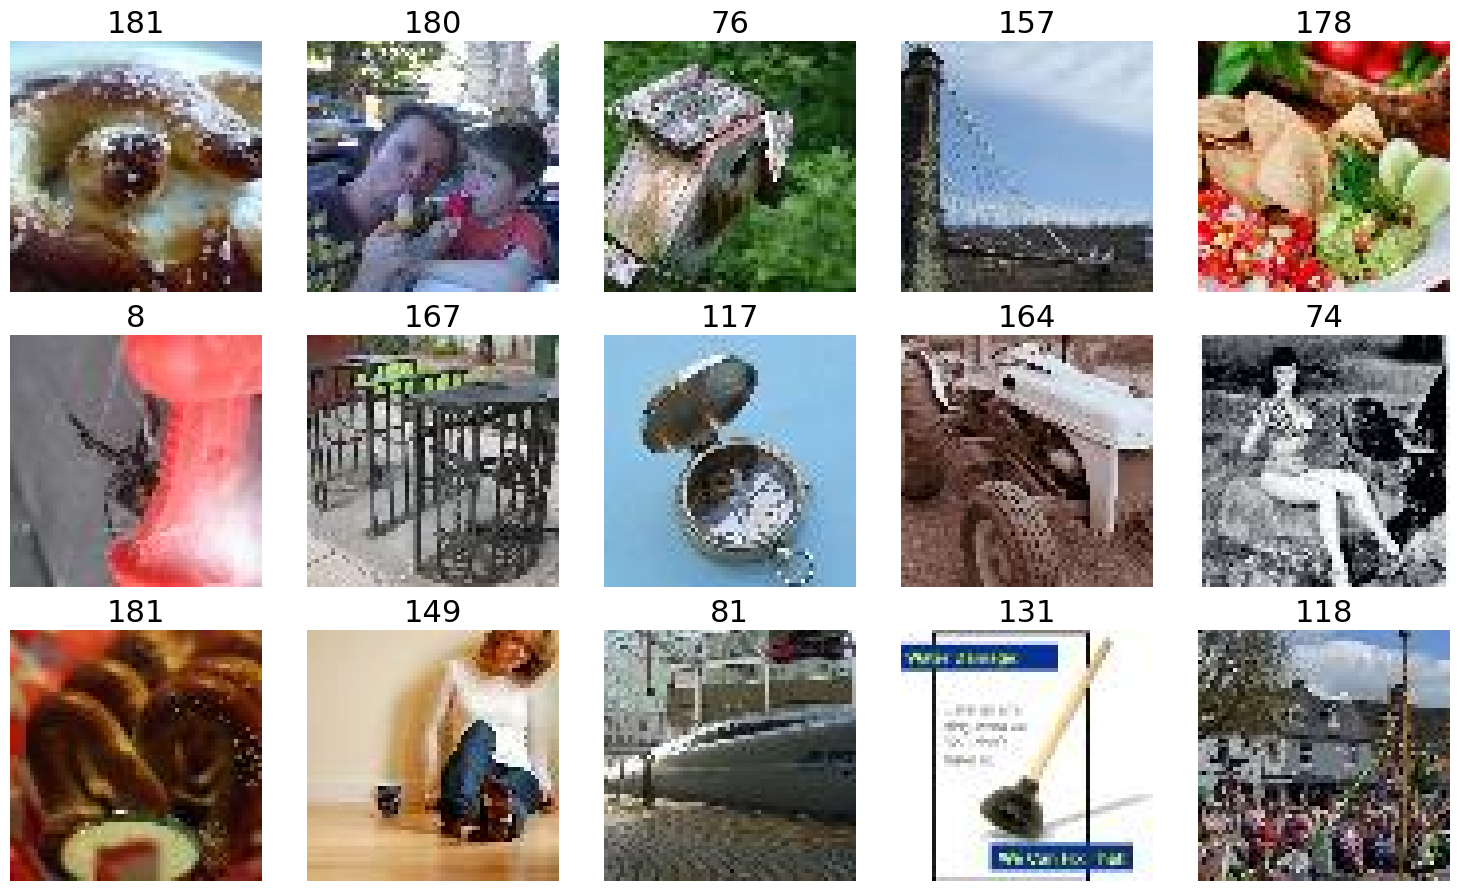

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

shuffled = ds_train.shuffle(seed=50)

for i, ax in enumerate(axes.flat):
    example = shuffled[i]
    image = example["image"]
    label = example.get("label", None)

    ax.imshow(image, cmap="gray")
    if label is not None:
        ax.set_title(str(label), fontsize=22)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Loading the CLIP Processor and Model
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch16"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Let's convert the 'label' format in human readable classes, since CLIP is trained on this type of labels instead of WordNet Synset IDs (n02086240, n02105641, etc.).

In [7]:
import requests

# URL with mapping WordNet ID -> human label (JSON)
words_url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"

response = requests.get(words_url)
wnid_to_name_full = response.json()

# mapping wnid -> human name
wnid_to_name = {wnid: name for (_, (wnid, name)) in wnid_to_name_full.items()}

# dataset classes are labeld with WordNet IDs
original_id2label = {id: label for id, label in enumerate(ds_train.features['label'].names)}

readable_id2label = {id: wnid_to_name.get(wnid, wnid) for id, wnid in original_id2label.items()}
readable_label2id = {name: id for id, name in readable_id2label.items()}

for i in range(10):
    print(f"{i}: {readable_id2label[i]}")


0: goldfish
1: European_fire_salamander
2: bullfrog
3: tailed_frog
4: American_alligator
5: boa_constrictor
6: trilobite
7: scorpion
8: black_widow
9: tarantula


Evaluating Zero-Shot Performance:   0%|          | 0/4923 [00:00<?, ?it/s]

Evaluating Zero-Shot Performance: 100%|██████████| 4923/4923 [03:22<00:00, 24.31it/s]


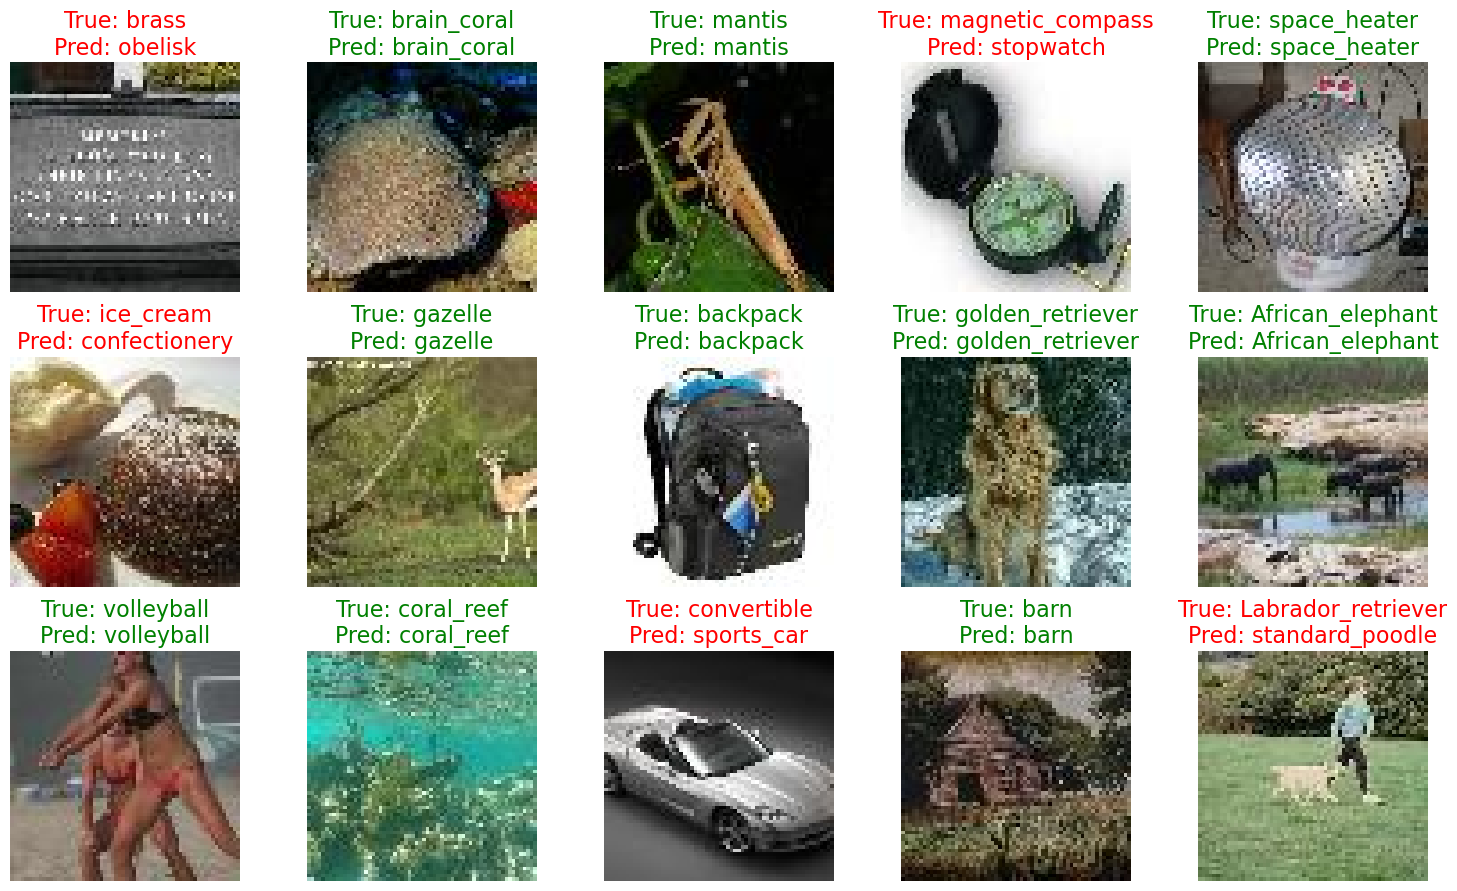


 Zero-shot Accuracy on test set: 0.6116


In [8]:
from src.functions import zero_shot_classification, zero_shot_classification_with_plots

zero_shot_accuracy = zero_shot_classification_with_plots(ds_test.shuffle(seed=50), model, processor, device, readable_id2label)
print(f"\n Zero-shot Accuracy on test set: {zero_shot_accuracy:.4f}")

##### Time to fine-tune the CLIPModel

Fine-tuning by including a classifier for subcategories

In [ ]:
import torch.nn as nn

class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)


Fine-tuning with LoRA

In [9]:
# Preprocessing
def transform(examples):
    inputs = processor(images=[img.convert("RGB") for img in examples['image']], return_tensors="pt")
    inputs['labels'] = examples['label']
    return inputs

ds_train_t = ds_train.with_transform(transform)
ds_validation_t = ds_validation.with_transform(transform)

In [13]:
from peft import LoraConfig, get_peft_model
from PIL import Image
from src.CLIP_utils import CLIPForClassification

model_ft = CLIPModel.from_pretrained(
    model_id,
    id2label=readable_id2label,
    label2id=readable_label2id
).to(device)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
)

# PEFT model
peft_model = get_peft_model(model_ft, lora_config)
peft_model.print_trainable_parameters()


num_labels = len(ds_train.features['label'].names)

model_ft = CLIPForClassification(peft_model, num_labels).to(device)

training_args = TrainingArguments(
    output_dir="./clip-tiny-imagenet-finetuned",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2, 
    learning_rate=5e-5,
    logging_steps=10,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False, 
)


# Funzione per calcolare le metriche
#def compute_metrics(p):
#    preds = np.argmax(p.predictions, axis=1)
#    return {"accuracy": accuracy_score(p.label_ids, preds)}

def evaluate_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=ds_train_t,
    eval_dataset=ds_validation_t,
    compute_metrics=evaluate_metrics,
)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f4be26bbb60>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f4a801d2150, raw_cell="from peft import LoraConfig, get_peft_model
from P.." transformed_cell="from peft import LoraConfig, get_peft_model
from P.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Blannister.micc.unifi.it/home/aspinaci/Deep-Learning-Applications-Labs/LAB3/Lab3-Transformers-new.ipynb#Y101sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

trainable params: 983,040 || all params: 150,603,777 || trainable%: 0.6527
Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f4be26bbb60>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f4a801d2210, execution_count=13 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f4a801d2150, raw_cell="from peft import LoraConfig, get_peft_model
from P.." transformed_cell="from peft import LoraConfig, get_peft_model
from P.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Blannister.micc.unifi.it/home/aspinaci/Deep-Learning-Applications-Labs/LAB3/Lab3-Transformers-new.ipynb#Y101sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [12]:
print("\nStarting LoRA fine-tuning...")
trainer.train()


Starting LoRA fine-tuning...


wandb: Currently logged in as: alessandraspin (alessandraspin-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/aspinaci/miniconda3/envs/transformers/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f4be26bbb60>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f4be6358460, execution_count=12 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f4be63586d0, raw_cell="print("\nStarting LoRA fine-tuning...")
trainer.tr.." transformed_cell="print("\nStarting LoRA fine-tuning...")
trainer.tr.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Blannister.micc.unifi.it/home/aspinaci/Deep-Learning-Applications-Labs/LAB3/Lab3-Transformers-new.ipynb#Y103sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
print("\nEvaluation of the fine-tuned model on the test set...")
ds_test_t = ds_test.with_transform(transform)
final_metrics = trainer.evaluate(eval_dataset=ds_test_t)

print(f"Zero-shot Accuracy (baseline): {zero_shot_accuracy:.4f}")
print(f"Accuracy post Fine-tuning: {final_metrics['eval_accuracy']:.4f}")